In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_path = 'train-processed.csv'
df = pd.read_csv(data_path)
texts = df['tokens'].astype(str).tolist()
y = df['sentiment'].tolist()



In [5]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 100
X = pad_sequences(sequences, padding='post', maxlen=max_len)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = np.array(y_train, dtype=np.int32)
y_val = np.array(y_val, dtype=np.int32)

In [6]:
def build_cnn_lstm_model():
    model = Sequential([
        Embedding(input_dim=5000, output_dim=32),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        LSTM(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_gru_model():
    model = Sequential([
        Embedding(input_dim=5000, output_dim=64),
        GRU(64, return_sequences=True),
        BatchNormalization(),
        GRU(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
model_cnn_lstm = build_cnn_lstm_model()
model_lstm = build_lstm_model()
model_gru = build_gru_model()


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])
    
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"{model_name} Validation Loss: {val_loss}")
    print(f"{model_name} Validation Accuracy: {val_accuracy}")
    
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_val, y_pred, target_names=['Negative', 'Positive']))
    
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    y_pred_proba = model.predict(X_val).ravel()
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return model, val_accuracy, roc_auc

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 408s 20ms/step - accuracy: 0.7749 - loss: 0.4664 - val_accuracy: 0.8032 - val_loss: 0.4279
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 397s 20ms/step - accuracy: 0.8201 - loss: 0.4019 - val_accuracy: 0.8200 - val_loss: 0.3944
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 424s 21ms/step - accuracy: 0.8262 - loss: 0.3907 - val_accuracy: 0.8255 - val_loss: 0.3871
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 457s 23ms/step - accuracy: 0.8288 - loss: 0.3861 - val_accuracy: 0.8254 - val_loss: 0.3920
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 435s 22ms/step - accuracy: 0.8306 - loss: 0.3834 - val_accuracy: 0.8282 - val_loss: 0.3822
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8284 - loss: 0.3811
CNN-LSTM Validation Loss: 0.3822219669818878
CNN-LSTM Validation Accuracy: 0.8282406330108643
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
Classification Report for CNN-LSTM:
              precision    recall  f1-score   support

    Negative       

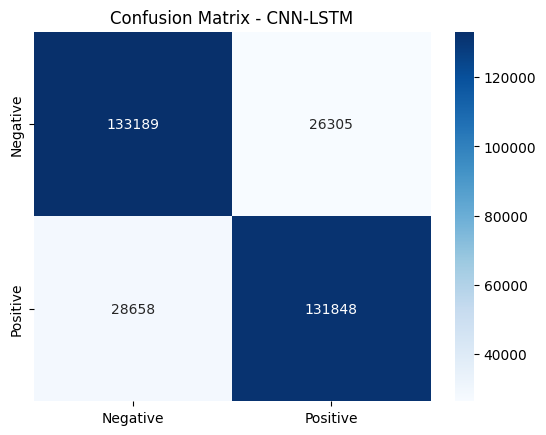

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step


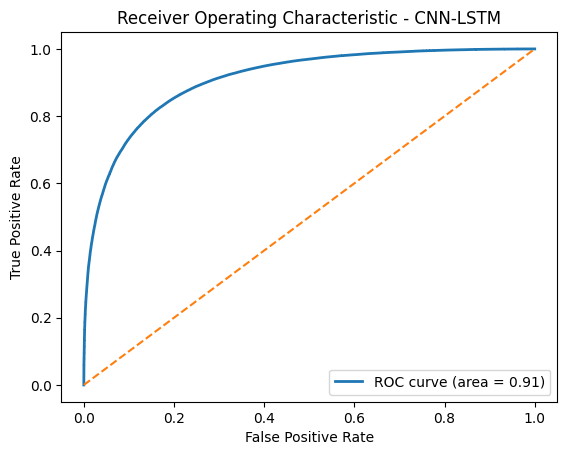

In [9]:
model_cnn_lstm, val_acc_cnn_lstm, roc_auc_cnn_lstm = train_and_evaluate_model(model_cnn_lstm, 'CNN-LSTM', X_train, y_train, X_val, y_val)



Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1252s 63ms/step - accuracy: 0.5015 - loss: 0.6927 - val_accuracy: 0.7897 - val_loss: 0.4464
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1346s 67ms/step - accuracy: 0.8061 - loss: 0.4246 - val_accuracy: 0.8211 - val_loss: 0.3909
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1373s 69ms/step - accuracy: 0.8275 - loss: 0.3857 - val_accuracy: 0.8265 - val_loss: 0.3808
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1305s 65ms/step - accuracy: 0.8364 - loss: 0.3694 - val_accuracy: 0.8303 - val_loss: 0.3767
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1273s 64ms/step - accuracy: 0.8427 - loss: 0.3579 - val_accuracy: 0.8325 - val_loss: 0.3720
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 107s 11ms/step - accuracy: 0.8325 - loss: 0.3716
LSTM Validation Loss: 0.37200459837913513
LSTM Validation Accuracy: 0.8324999809265137
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step
Classification Report for LSTM:
              precision    recall  f1-score   support

    Negative       0.

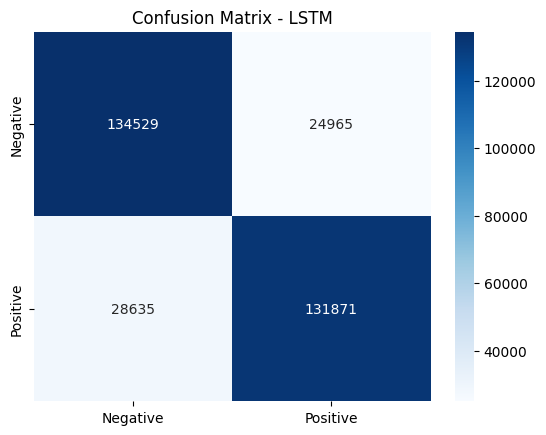

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 10ms/step


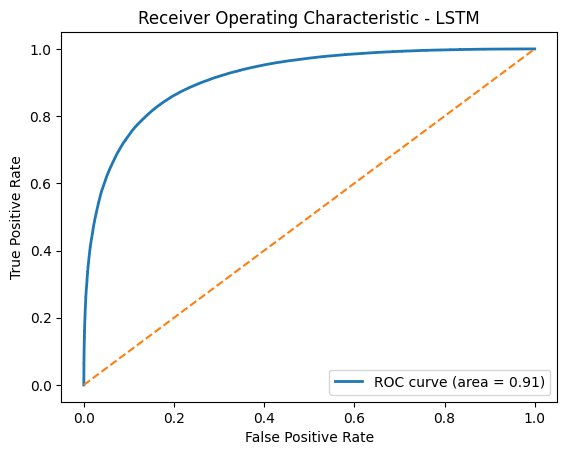

In [10]:
model_lstm, val_acc_lstm, roc_auc_lstm = train_and_evaluate_model(model_lstm, 'LSTM', X_train, y_train, X_val, y_val)


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1154s 58ms/step - accuracy: 0.5003 - loss: 0.6935 - val_accuracy: 0.4985 - val_loss: 0.6932
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1153s 58ms/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.4985 - val_loss: 0.6932
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1229s 61ms/step - accuracy: 0.5201 - loss: 0.6769 - val_accuracy: 0.8039 - val_loss: 0.4200
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step - accuracy: 0.4992 - loss: 0.6932
GRU Validation Loss: 0.6932286620140076
GRU Validation Accuracy: 0.4984937608242035
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 101s 10ms/step
Classification Report for GRU:
              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67    159494
    Positive       0.68      0.00      0.00    160506

    accuracy                           0.50    320000
   macro avg       0.59      0.50      0.33    320000
weighted avg       0.59      0.50      0.33    320000



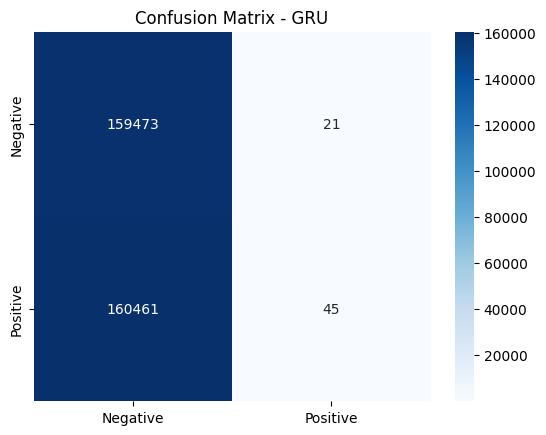

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step


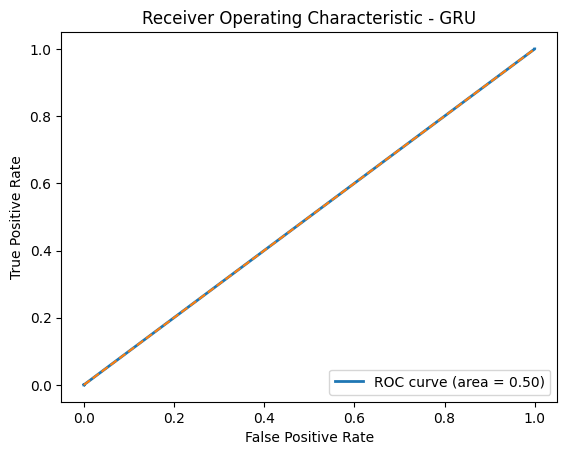

In [12]:
model_gru, val_acc_gru, roc_auc_gru = train_and_evaluate_model(model_gru, 'GRU', X_train, y_train, X_val, y_val)



In [49]:
import pandas as pd

def evaluate_model_on_new_data(model, X_new, true_labels_binary, model_name, df_new):
    y_pred_proba = model.predict(X_new).ravel()
    y_pred = (y_pred_proba > 0.5).astype("int32")
    
    # Update the existing dataframe with predictions and confidence
    df_new[model_name + '_predicted_sentiment'] = y_pred
    df_new[model_name + '_prediction_confidence'] = y_pred_proba
    
    # Create a DataFrame to return that includes the model name
    df_results = pd.DataFrame({
        'True_Label': true_labels_binary,
        'Predicted_Label': y_pred,
        'Prediction_Confidence': y_pred_proba,
        'Model': model_name
    })
    
    print(f"\nClassification Report for {model_name} on New Data:")
    print(classification_report(true_labels_binary, y_pred, target_names=['Not Positive', 'Positive']))
    
    print(f"\nConfusion Matrix for {model_name} on New Data:")
    cm = confusion_matrix(true_labels_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Positive', 'Positive'], yticklabels=['Not Positive', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name} on New Data')
    plt.show()

    roc_auc = roc_auc_score(true_labels_binary, y_pred_proba)
    print(f"ROC AUC for {model_name} on New Data: {roc_auc:.2f}")
    
    # Return the predictions, confidence, and the DataFrame
    return y_pred, y_pred_proba, df_results



In [50]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the new dataset
data_path = 'quora and discord.csv'  # Update with the correct file path
df_quora_discord = pd.read_csv(data_path)

# Display first few rows to ensure data is loaded correctly
print(df_quora_discord.head())

# Preprocess the text data
texts_quora_discord = df_quora_discord['clean_text'].astype(str).tolist()

# Assuming 'category' column contains the true sentiment labels
true_labels_quora_discord = df_quora_discord['category']
true_labels_binary_quora_discord = (true_labels_quora_discord == 1).astype(int)

# Use the same tokenizer and max_len as used in training
sequences_quora_discord = tokenizer.texts_to_sequences(texts_quora_discord)
max_len = 100  # Ensure this is consistent with the max_len used in training
X_quora_discord = pad_sequences(sequences_quora_discord, padding='post', maxlen=max_len)

                                          clean_text  category
0  talk all the nonsense and continue all the dra...         0
1  what did just say vote for modi  welcome bjp t...         1
2  asking his supporters prefix chowkidar their n...         1
3  answer who among these the most powerful world...         1
4           kiya tho refresh maarkefir comment karo          0


3984/3984 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step

Classification Report for CNN-LSTM on New Data:
              precision    recall  f1-score   support

Not Positive       0.66      0.54      0.59     55213
    Positive       0.69      0.78      0.73     72250

    accuracy                           0.68    127463
   macro avg       0.67      0.66      0.66    127463
weighted avg       0.68      0.68      0.67    127463


Confusion Matrix for CNN-LSTM on New Data:


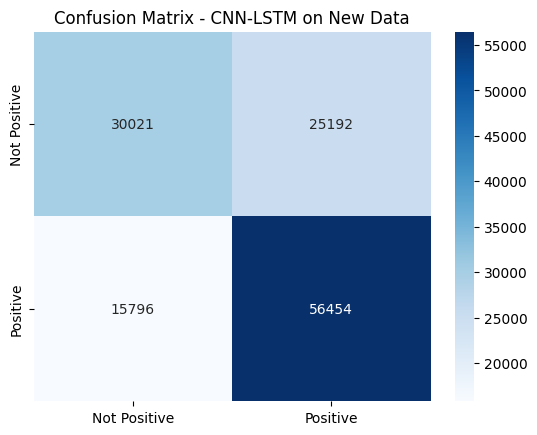

ROC AUC for CNN-LSTM on New Data: 0.73
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step

Classification Report for LSTM on New Data:
              precision    recall  f1-score   support

Not Positive       0.68      0.44      0.54     55213
    Positive       0.66      0.84      0.74     72250

    accuracy                           0.67    127463
   macro avg       0.67      0.64      0.64    127463
weighted avg       0.67      0.67      0.65    127463


Confusion Matrix for LSTM on New Data:


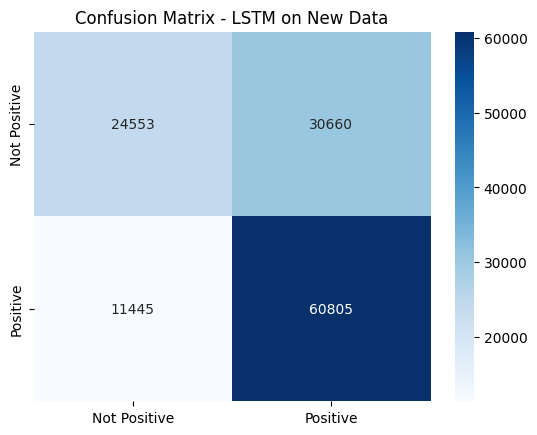

ROC AUC for LSTM on New Data: 0.73
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step

Classification Report for GRU on New Data:
              precision    recall  f1-score   support

Not Positive       0.00      0.00      0.00     55213
    Positive       0.57      1.00      0.72     72250

    accuracy                           0.57    127463
   macro avg       0.28      0.50      0.36    127463
weighted avg       0.32      0.57      0.41    127463


Confusion Matrix for GRU on New Data:


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

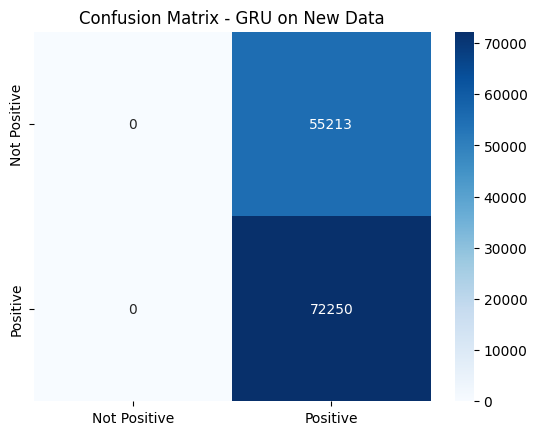

ROC AUC for GRU on New Data: 0.50
Combined predictions have been exported to 'quora_discord_combined_predictions.csv'


In [52]:
# Evaluate CNN-LSTM Model
_, _, df_cnn_lstm_results = evaluate_model_on_new_data(model_cnn_lstm, X_quora_discord, true_labels_binary_quora_discord, 'CNN-LSTM', df_quora_discord)

# Evaluate LSTM Model
_, _, df_lstm_results = evaluate_model_on_new_data(model_lstm, X_quora_discord, true_labels_binary_quora_discord, 'LSTM', df_quora_discord)

# Evaluate GRU Model
_, _, df_gru_results = evaluate_model_on_new_data(model_gru, X_quora_discord, true_labels_binary_quora_discord, 'GRU', df_quora_discord)

# Combine all results into one DataFrame
df_combined_results = pd.concat([df_cnn_lstm_results, df_lstm_results, df_gru_results], axis=0)

# Save the combined results to a CSV file
df_combined_results.to_csv('quora_discord_combined_predictions.csv', index=False)

print("Combined predictions have been exported to 'quora_discord_combined_predictions.csv'")


In [41]:
performance_data = {
    'Model': ['CNN-LSTM', 'LSTM', 'GRU'],
    'Validation Accuracy': [val_acc_cnn_lstm, val_acc_lstm, val_acc_gru],
    'ROC AUC': [roc_auc_cnn_lstm, roc_auc_lstm, roc_auc_gru]
}

df_performance = pd.DataFrame(performance_data)
df_performance.to_csv('model_performance.csv', index=False)
print("Model performance metrics have been exported to 'model_performance.csv'")


Model performance metrics have been exported to 'model_performance.csv'


In [42]:
def save_confusion_matrix(cm, model_name):
    cm_df = pd.DataFrame(cm, index=['Actual Not Positive', 'Actual Positive'], columns=['Predicted Not Positive', 'Predicted Positive'])
    cm_df.to_csv(f'{model_name}_confusion_matrix.csv')
    print(f"Confusion matrix for {model_name} has been exported.")

save_confusion_matrix(confusion_matrix(y_val, (model_cnn_lstm.predict(X_val) > 0.5).astype("int32")), 'CNN-LSTM')
save_confusion_matrix(confusion_matrix(y_val, (model_lstm.predict(X_val) > 0.5).astype("int32")), 'LSTM')
save_confusion_matrix(confusion_matrix(y_val, (model_gru.predict(X_val) > 0.5).astype("int32")), 'GRU')


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step
Confusion matrix for CNN-LSTM has been exported.
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step
Confusion matrix for LSTM has been exported.
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 10ms/step
Confusion matrix for GRU has been exported.


In [47]:
def save_roc_data(fpr, tpr, thresholds, model_name):
    roc_data = pd.DataFrame({
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    })
    roc_data.to_csv(f'{model_name}_roc_curve.csv', index=False)
    print(f"ROC curve data for {model_name} has been exported.")

fpr_cnn_lstm, tpr_cnn_lstm, thresholds_cnn_lstm = roc_curve(y_val, model_cnn_lstm.predict(X_val).ravel())
save_roc_data(fpr_cnn_lstm, tpr_cnn_lstm, thresholds_cnn_lstm, 'CNN-LSTM')

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_val, model_lstm.predict(X_val).ravel())
save_roc_data(fpr_lstm, tpr_lstm, thresholds_lstm, 'LSTM')

fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_val, model_gru.predict(X_val).ravel())
save_roc_data(fpr_gru, tpr_gru, thresholds_gru, 'GRU')


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step
ROC curve data for CNN-LSTM has been exported.
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step
ROC curve data for LSTM has been exported.
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 99s 10ms/step
ROC curve data for GRU has been exported.


In [46]:
def save_error_analysis(df, model_name):
    error_df = df[(df['category'] != df[f'{model_name}_predicted_sentiment'])]
    error_df.to_csv(f'{model_name}_errors.csv', index=False)
    print(f"Error analysis for {model_name} has been exported.")

save_error_analysis(df_quora_discord, 'CNN-LSTM')
save_error_analysis(df_quora_discord, 'LSTM')
save_error_analysis(df_quora_discord, 'GRU')


Error analysis for CNN-LSTM has been exported.
Error analysis for LSTM has been exported.
Error analysis for GRU has been exported.


In [53]:
import pandas as pd

# Assume confusion_matrix, roc_auc_score, etc., are already computed for each model
# These are placeholders for actual values you'd have computed from the models
# Example values (use actual results from your models)
cm_cnn_lstm = confusion_matrix(y_val, (model_cnn_lstm.predict(X_val) > 0.5).astype("int32"))
cm_lstm = confusion_matrix(y_val, (model_lstm.predict(X_val) > 0.5).astype("int32"))
cm_gru = confusion_matrix(y_val, (model_gru.predict(X_val) > 0.5).astype("int32"))

roc_auc_cnn_lstm = roc_auc_cnn_lstm
roc_auc_lstm = roc_auc_lstm
roc_auc_gru = roc_auc_gru

# Assuming errors are calculated similarly (binary outcomes)
error_rate_cnn_lstm = 1 - val_acc_cnn_lstm
error_rate_lstm = 1 - val_acc_lstm
error_rate_gru = 1 - val_acc_gru

# Summarizing the confusion matrix
def summarize_confusion_matrix(cm):
    tn, fp, fn, tp = cm.ravel()
    return {
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp
    }

# Summarize confusion matrices for each model
summary_cnn_lstm = summarize_confusion_matrix(cm_cnn_lstm)
summary_lstm = summarize_confusion_matrix(cm_lstm)
summary_gru = summarize_confusion_matrix(cm_gru)

# Create a DataFrame with all the combined data
data_summary = {
    'Model': ['CNN-LSTM', 'LSTM', 'GRU'],
    'True Negative': [summary_cnn_lstm['True Negative'], summary_lstm['True Negative'], summary_gru['True Negative']],
    'False Positive': [summary_cnn_lstm['False Positive'], summary_lstm['False Positive'], summary_gru['False Positive']],
    'False Negative': [summary_cnn_lstm['False Negative'], summary_lstm['False Negative'], summary_gru['False Negative']],
    'True Positive': [summary_cnn_lstm['True Positive'], summary_lstm['True Positive'], summary_gru['True Positive']],
    'ROC AUC': [roc_auc_cnn_lstm, roc_auc_lstm, roc_auc_gru],
    'Error Rate': [error_rate_cnn_lstm, error_rate_lstm, error_rate_gru]
}

df_summary = pd.DataFrame(data_summary)

# Save the combined summary DataFrame to a CSV file
df_summary.to_csv('model_summary_metrics1.csv', index=False)

print("Model summary metrics have been exported to 'model_summary_metrics.csv'")


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 104s 10ms/step
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 100s 10ms/step
Model summary metrics have been exported to 'model_summary_metrics.csv'


In [54]:
import pandas as pd

# Combine the performance metrics into a single DataFrame
performance_data = {
    'Model': ['CNN-LSTM', 'LSTM', 'GRU'],
    'Validation_Accuracy': [val_acc_cnn_lstm, val_acc_lstm, val_acc_gru],
    'ROC_AUC': [roc_auc_cnn_lstm, roc_auc_lstm, roc_auc_gru]
}

df_performance = pd.DataFrame(performance_data)

# Save the combined performance metrics to a CSV file
df_performance.to_csv('combined_model_performance.csv', index=False)
print("Combined model performance metrics have been exported to 'combined_model_performance.csv'")

Combined model performance metrics have been exported to 'combined_model_performance.csv'
